In [261]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
%matplotlib inline

In [2]:
df = pd.read_csv('cnndata2.csv')

In [3]:
# Drop the duplicate rows as we won't be using the sentences as our unit of analysis.
data = df.drop_duplicates(subset='thread.title', keep='first').copy()

In [60]:
data.head()

,Month_Day,Week_of_Year,thread.site,text,thread.country,thread.title,thread.url,thread_total_interactions,V1,thread_sentences,title_pol,title_sub,text_pol,text_sub
0,1-26,4.0,foxnews.com,THE PATIENT HAD RECENTLY RETURNED FROM WUHAN C...,EU,California case of coronavirus is 3rd confirme...,https://www.foxnews.com/health/third-case-of-c...,16115,THE PATIENT HAD RECENTLY RETURNED FROM WUHAN C...,13,0.2,0.5,0.091742,0.502955
13,1-26,4.0,foxnews.com,THE MAJORITY OF THE INFECTIONS AND ALL THE DEA...,US,"Coronavirus: 41 dead and 1,300 infected as Can...",https://www.foxnews.com/health/coronavirus-upd...,25813,THE MAJORITY OF THE INFECTIONS AND ALL THE DEA...,24,-0.2,0.4,0.100551,0.487590
37,1-30,5.0,foxnews.com,THOSE CURRENTLY IN CHINA SHOULD CONSIDER DEPAR...,EU,"State Department, citing coronavirus outbreak,...",https://www.foxnews.com/health/state-departmen...,12861,THOSE CURRENTLY IN CHINA SHOULD CONSIDER DEPAR...,22,0.0,0.0,0.009141,0.400101
59,1-31,5.0,foxnews.com,DR. ROBERT REDFIELD THE CDC DIRECTOR SAID THE ...,EU,Person-to-person transmission of coronavirus r...,https://www.foxnews.com/health/person-to-perso...,17165,ROBERT REDFIELD THE CDC DIRECTOR SAID THE HEA...,13,0.0,0.0,0.050624,0.407576
71,1-30,5.0,foxnews.com,THE WORLD HEALTH ORGANIZATION DEFINES A GLOBAL...,US,WHO declares coronavirus outbreak a global eme...,http://video.foxnews.com/v/6128411974001/,115,THE WORLD HEALTH ORGANIZATION DEFINES A GLOBAL...,2,0.0,0.0,0.052083,0.343750


In [5]:
# Function of sentiment analysis
def sentiment(text):
    ''' The function takes a text and returns a tuple with the polarity and subjectivity scores. '''
    bolb = TextBlob(str(text))
    return bolb

In [320]:
# produce aggregated stats (median)
def gb(columns, by, data):
    d = data[columns+by].groupby(by).median()
    return d

In [6]:
# Calculate and add columns with the sentiment scores.

data['title_pol'] = data['thread.title'].apply(lambda x: sentiment(x).polarity) 
data['title_sub'] = data['thread.title'].apply(lambda x: sentiment(x).subjectivity)

data['text_pol'] = data['text'].apply(lambda x: sentiment(x).polarity) 
data['text_sub'] = data['text'].apply(lambda x: sentiment(x).subjectivity)

In [ ]:
# Relevant features
columns = ['thread_total_interactions', 'thread_sentences', 'title_pol', 'title_sub', 'text_pol', 'text_sub']

### Examine the distributions of the relevant features

In [325]:
# Calculate the median of social interactions, title_polarity etc. per news group.
# Take the median because it is expected that there are some extreem values.
gb(columns, by = ['thread.site'], data = data)

,thread_total_interactions,thread_sentences,title_pol,title_sub,text_pol,text_sub
thread.site,,,,,,
cnn.com,129,43,0.0,0.0,0.088365,0.421656
foxnews.com,120,22,0.0,0.1,0.095347,0.421581


In [356]:
def fplt(columns, by, data):
    for i in range(len(columns)):
        f.add_subplot(3, 2, i+1)
        sns.boxplot(x=by, y=columns[i], data=data)

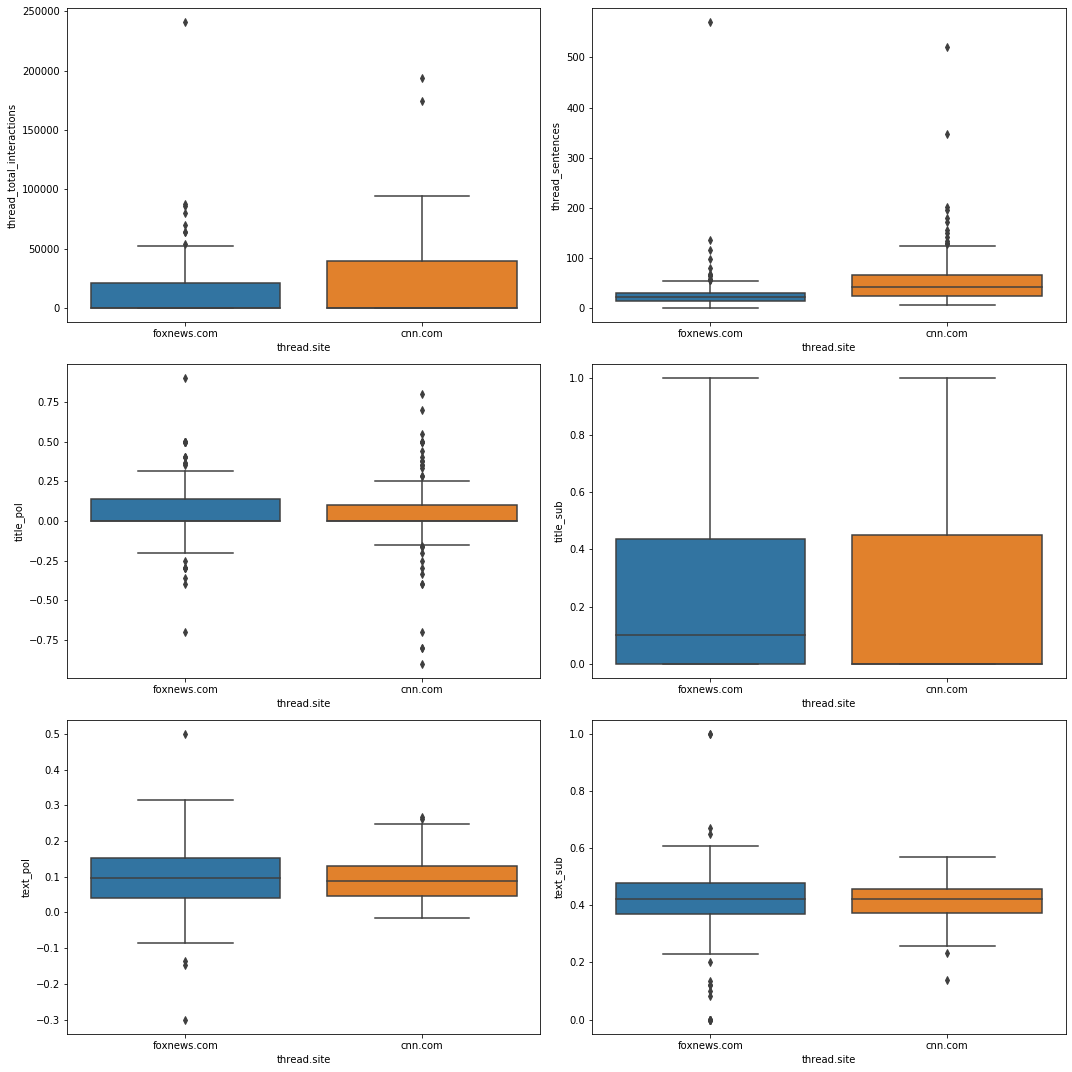

In [357]:
f = plt.figure(figsize = (15, 15))

fplt(columns, 'thread.site', data = data)

plt.tight_layout()

* Notice that overall the features seem to overlap between the news agencies, except the length of the articles. Fox seems to prefer shorter articles compared to CNN.
* It is somewhat expected to see a lot of outliers when it comes to the selected set of features.

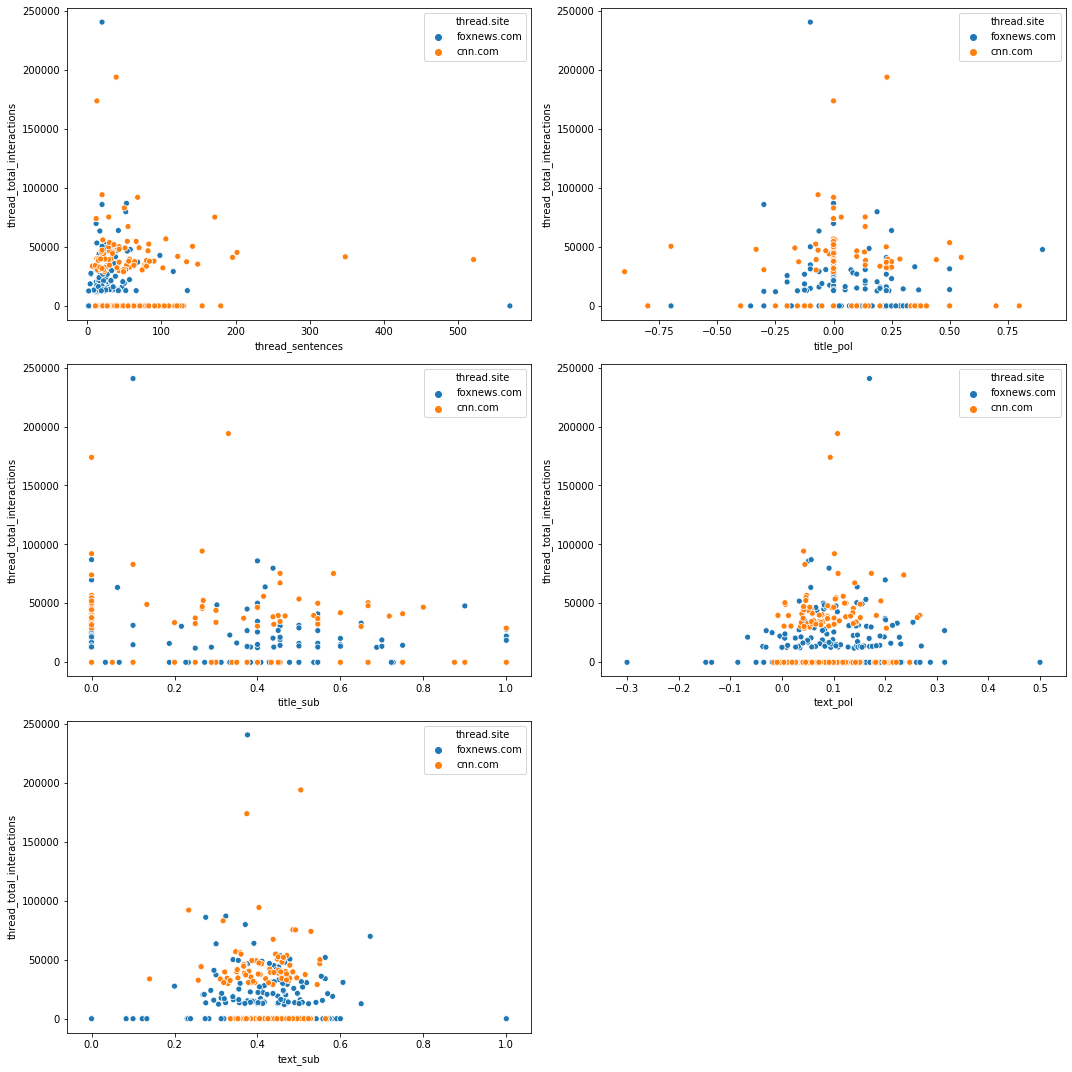

In [376]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.scatterplot(data.thread_sentences, data.thread_total_interactions, ax=axes[0, 0], hue=data['thread.site'])
sns.scatterplot(data.title_pol, data.thread_total_interactions, ax=axes[0, 1], hue=data['thread.site'])
sns.scatterplot(data.title_sub, data.thread_total_interactions, ax=axes[1, 0], hue=data['thread.site'])
sns.scatterplot(data.text_pol, data.thread_total_interactions,  ax=axes[1, 1], hue=data['thread.site'])
sns.scatterplot(data.text_sub, data.thread_total_interactions,  ax=axes[2, 0], hue=data['thread.site'])

f.delaxes(axes[2,1])
plt.tight_layout()

* There seem to be no meaningfull pattern between the set of features and social interactions.

### Let's take a look at the aggregated statistics.
2. By news company, Month_Day

In [324]:
pd.options.display.max_rows = 82
aggr = gb(columns,by = ['thread.site', 'Month_Day'], data = data)

In [306]:
# Before looking at the features let's see if there is any periodicity in the number of articles produced by month_day
x = data[['thread.site', 'Month_Day', 'Week_of_Year']].groupby(['thread.site', 'Month_Day']).count()

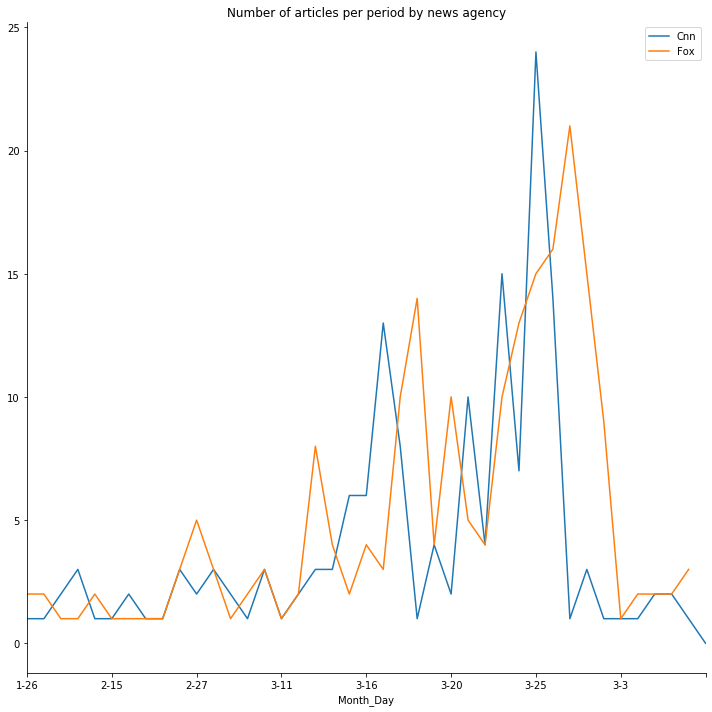

In [382]:
f, a = plt.subplots()

x['Week_of_Year'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
x['Week_of_Year'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

a.legend(['Cnn', 'Fox'])
plt.title('Number of articles per period by news agency')

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.tight_layout()

* There seems to be two spikes in the number of articles: the March 16-17, and march 25.

#### Total interactions per period by news agency.

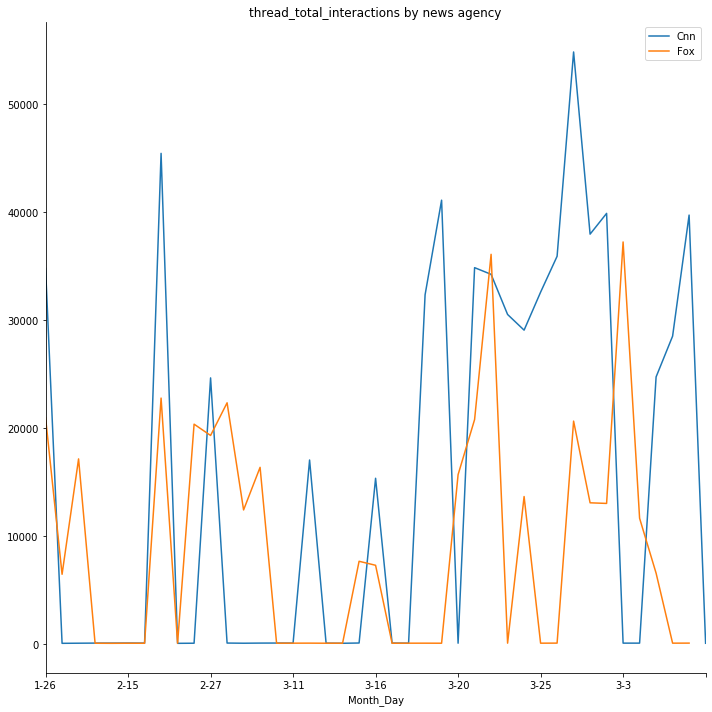

In [229]:
f, a = plt.subplots()

aggr['thread_total_interactions'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
aggr['thread_total_interactions'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

a.legend(['Cnn', 'Fox'])
plt.title('thread_total_interactions by news agency')

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)

plt.tight_layout()

* The overall pattern seem to be the same.
* Although, it seems as if Fox seems to produce articles more often compared to CNN. However, the social interactions of the produced articles seems to be higher for the articles by CNN compared to Fox.
* There seems to be high "social interactions" with CNN articles late march: this is perhaps when the lock-down went into effect.

#### Length of the text (sentences) per period by news agency.

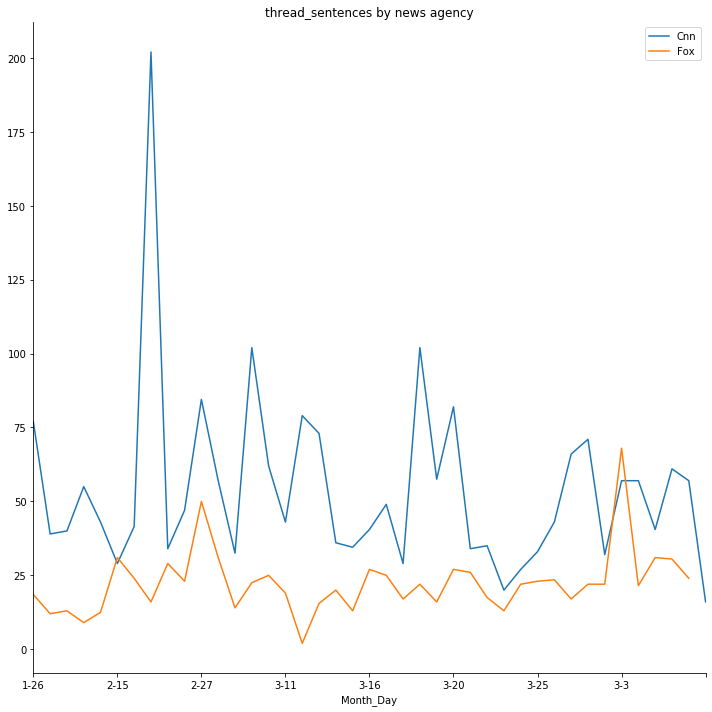

In [308]:
f, a = plt.subplots()

aggr['thread_sentences'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
aggr['thread_sentences'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

plt.title('thread_sentences by news agency')
a.legend(['Cnn', 'Fox'])

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
plt.tight_layout()

* Overall, the length of the articles is higher for CNN compared to Fox. 
* The variation in the length seems to be also higher for CNN whereas for Fox seem to produce articles of similar lengths over time.

#### Sentiment of the articles per period by news agency.

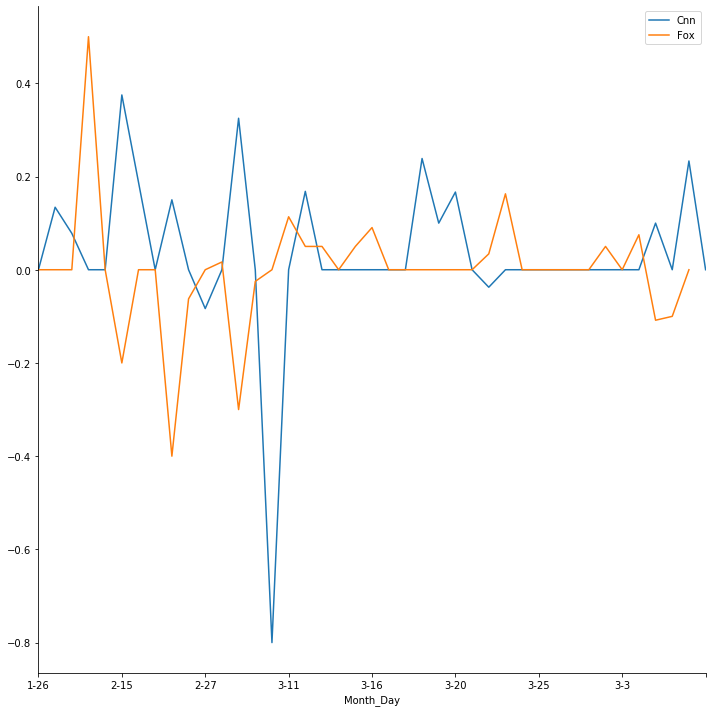

In [309]:
f, a = plt.subplots()

aggr['title_pol'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
aggr['title_pol'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

a.legend(['Cnn', 'Fox'])

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
plt.tight_layout()

* The polarity of the titles for the same period seem to be different for CNN and FOX. When CNN is positive Fox seem to be negative and vise versa. 
* Whenever the titles from CNN are neutral (0) titles of the articles from Fox seem to be positive. 

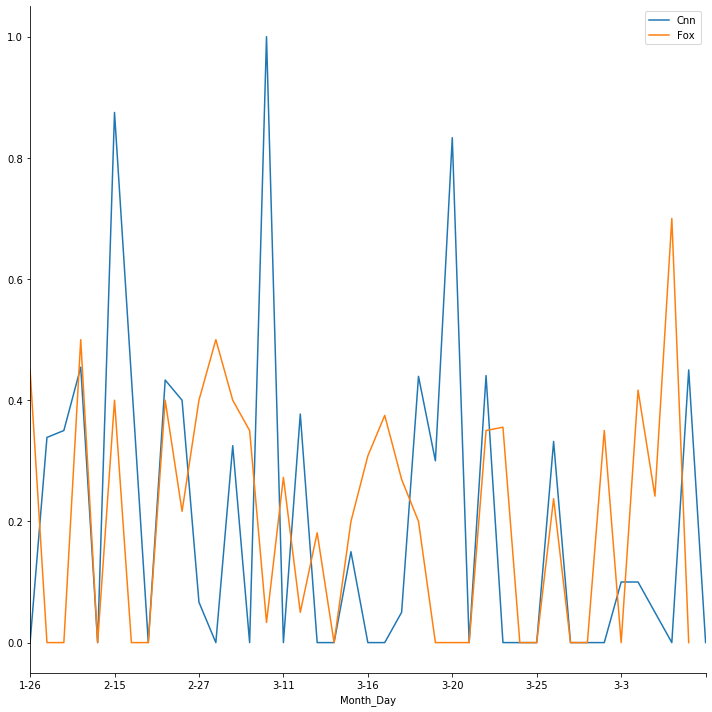

In [311]:
f, a = plt.subplots()

aggr['title_sub'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
aggr['title_sub'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

a.legend(['Cnn', 'Fox'])

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
plt.tight_layout()

* For most part the subjectvity scores for the titles seem to overlap between the two. 
* However, from January to March 25 it seems like (for most part) whenever CNN writes subjective titles they seem to be more subjective then ones written by Fox. 

In [ ]:
# polarity of the text

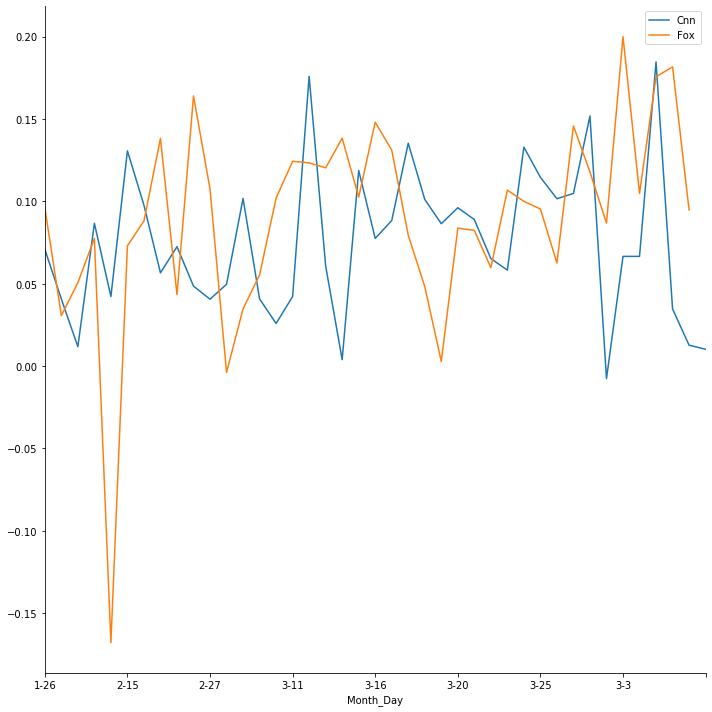

In [312]:
f, a = plt.subplots()

aggr['text_pol'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
aggr['text_pol'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

a.legend(['Cnn', 'Fox'])

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
plt.tight_layout()

* Seems like the polarity of the text have the same valence for both agencies.
* The polarity is either neutral or positive for most part (except an article produced by Fox in the end of January).

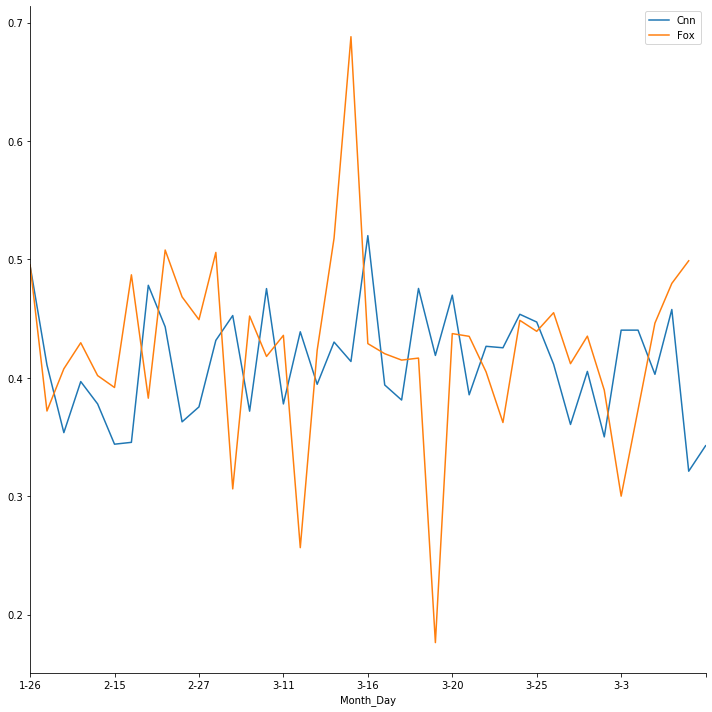

In [313]:
f, a = plt.subplots()

aggr['text_sub'].xs('cnn.com').plot(kind='line',ax=a, figsize=(10, 10))
aggr['text_sub'].xs('foxnews.com').plot(kind='line',ax=a, figsize=(10, 10))

a.legend(['Cnn', 'Fox'])

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
plt.tight_layout()

* Seems to be overlapping. Maybe a bit more variation in Fox articles

### Now let's create categories of low, medium and high social_interaction categories

* Create a subset of Fox and CNN articles and create L, M, H categories based on the distribution of the social_interactions
* Run the aggregate statiscs on them.

In [314]:
cnn = data[data['thread.site'] == 'cnn.com']
fox = data[data['thread.site'] != 'cnn.com']

In [315]:
cnn.reset_index(drop=True, inplace=True)
fox.reset_index(drop=True, inplace=True)

In [14]:
cnn.thread_total_interactions.describe()

count       165.000000
mean      22633.224242
std       29982.492555
min         100.000000
25%         116.000000
50%         129.000000
75%       39396.000000
max      194036.000000
Name: thread_total_interactions, dtype: float64

In [15]:
fox.thread_total_interactions.describe()

count       209.000000
mean      14284.454545
std       23912.979737
min         100.000000
25%         110.000000
50%         120.000000
75%       21341.000000
max      240704.000000
Name: thread_total_interactions, dtype: float64

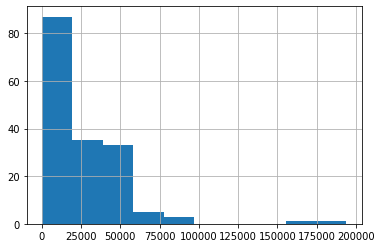

In [100]:
cnn.thread_total_interactions.hist()

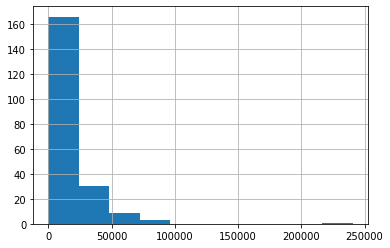

In [316]:
fox.thread_total_interactions.hist()

In [335]:
cnn['cat_int'] = pd.cut(cnn.thread_total_interactions,bins=[99, 129,55000, 194036],labels=['L','M','H'])
fox['cat_int'] = pd.cut(fox.thread_total_interactions,bins=[99, 120,50000, 240704],labels=['L','M','H'])

C:\Users\mkhit\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mkhit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


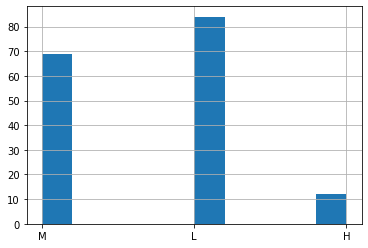

In [319]:
cnn.cat_int.hist()

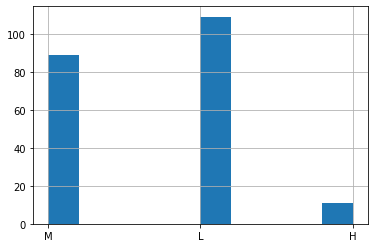

In [336]:
fox.cat_int.hist()

In [337]:
gb(columns, by = ['cat_int'], data = cnn)

,thread_total_interactions,thread_sentences,title_pol,title_sub,text_pol,text_sub
cat_int,,,,,,
L,116.0,41.0,0.0,0.000000,0.092902,0.425255
M,38029.0,43.0,0.0,0.200000,0.077941,0.406663
H,75455.5,34.0,0.0,0.183333,0.108336,0.420775


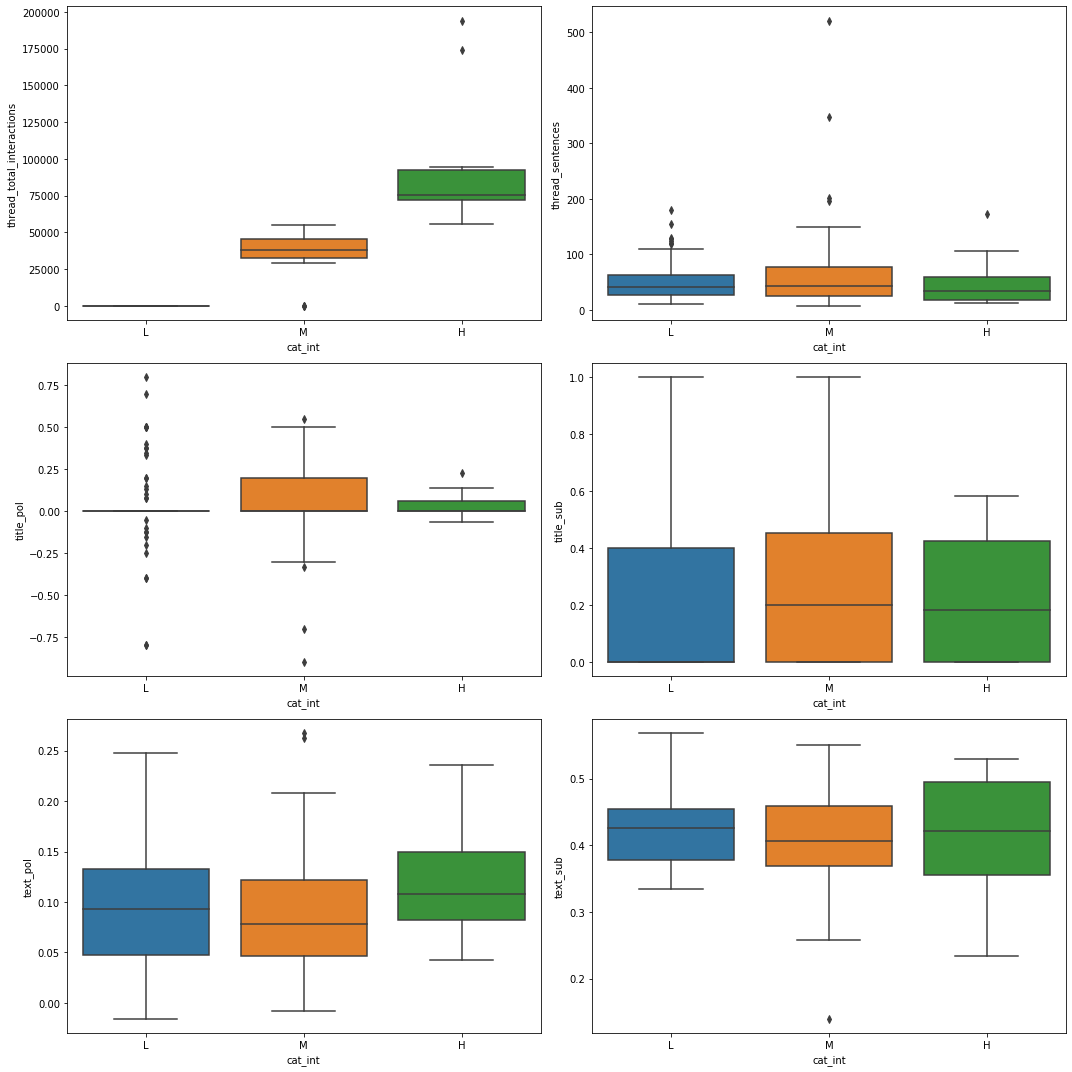

In [358]:
f = plt.figure(figsize = (15, 15))

fplt(columns, 'cat_int', data = cnn)

plt.tight_layout()

In [338]:
gb(columns, by = ['cat_int'], data = fox)

,thread_total_interactions,thread_sentences,title_pol,title_sub,text_pol,text_sub
cat_int,,,,,,
L,110,19,0.0,0.1000,0.097531,0.421581
M,20570,24,0.0,0.1875,0.095347,0.428922
H,64028,20,0.0,0.0625,0.091349,0.375962


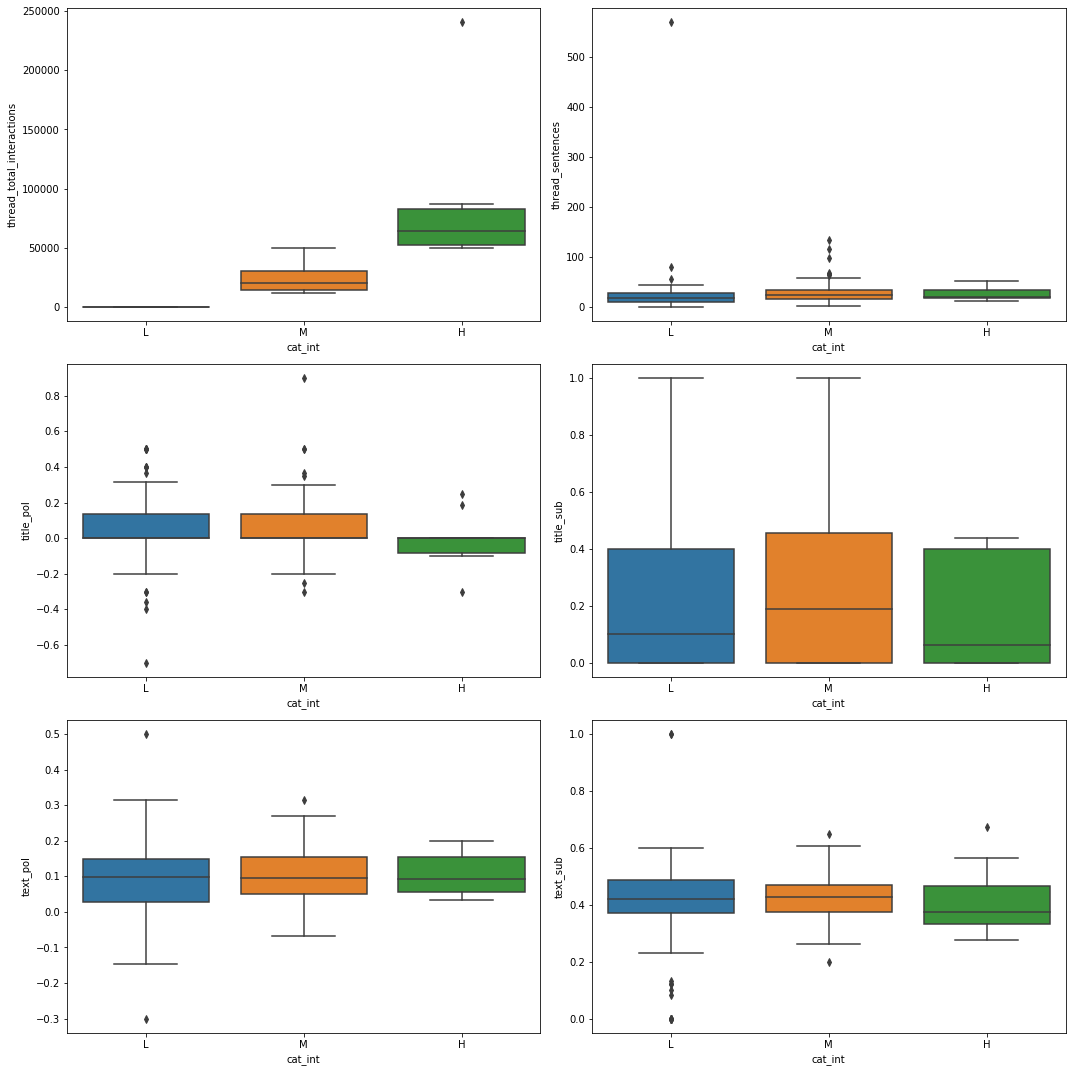

In [360]:
f = plt.figure(figsize = (15, 15))

fplt(columns, 'cat_int', data = fox)

plt.tight_layout()